In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import os
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import random


## Model loading

In [ ]:
class MaskedAutoEncoder(nn.Module):
    def __init__(self, in_dim=9, maskable_dim=4, embed_dim=64, depth=4):
        super().__init__()
        self.in_dim = in_dim
        self.maskable_dim = maskable_dim

        self.mask_token = nn.Parameter(torch.zeros(in_dim))

        layers = []
        for _ in range(depth):
            layers += [
                nn.Linear(embed_dim if layers else in_dim, embed_dim),
                nn.GELU(),
                nn.LayerNorm(embed_dim)
            ]
        self.encoder = nn.Sequential(*layers)

        self.decoder = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.GELU(),
            nn.Linear(embed_dim, in_dim)
        )

    def forward(self, x, mask):
        x = torch.where(mask, x, self.mask_token)
        z = self.encoder(x)
        return self.decoder(z)

In [ ]:
MODEL_PATH = 'model.pt'

In [ ]:
if os.path.exists(MODEL_PATH):
    print(f"Loading model from {MODEL_PATH}")
    model = MaskedAutoEncoder(in_dim=9, embed_dim=128).cuda()
    model.load_state_dict(torch.load(MODEL_PATH))
    model.eval()
else:
    print(f"MAE model not found!")

Loading model from model.pt


In [ ]:
for param in model.parameters():
    param.requires_grad = True


## Data loading

In [ ]:
def random_test_patches_mask(df: pd.DataFrame, grid_size=(20, 20), n_patches=10, seed=42) -> pd.Series:
    """
    Losuje n_patches z globalnej siatki i tworzy maskę testową.

    Args:
        df: DataFrame z kolumnami 'lat' i 'lon'.
        grid_size: (n_lat_bins, n_lon_bins) – ile kafli w pionie i poziomie.
        n_patches: ile patchy ma trafić do testu.
        seed: dla powtarzalności.

    Returns:
        test_mask: pd.Series[bool] z True dla testowych patchy.
    """
    lat_bins = np.linspace(df["lat"].min(), df["lat"].max(), grid_size[0] + 1)
    lon_bins = np.linspace(df["lon"].min(), df["lon"].max(), grid_size[1] + 1)

    lat_inds = np.digitize(df["lat"], bins=lat_bins) - 1
    lon_inds = np.digitize(df["lon"], bins=lon_bins) - 1

    patch_ids = lat_inds * grid_size[1] + lon_inds
    df = df.copy()
    df["patch_id"] = patch_ids

    unique_patches = df["patch_id"].unique()
    rng = np.random.default_rng(seed)
    test_patch_ids = rng.choice(unique_patches, size=n_patches, replace=False)

    test_mask = df["patch_id"].isin(test_patch_ids)
    return test_mask

In [ ]:
df = pd.read_parquet("./data/processed/salinity_00_train_data.parquet")
cols = ["temperature_00", "oxygen_00", "nitrate_00", "phosphate_00"]

def encode_geospatial_features(df: pd.DataFrame) -> np.ndarray:
    lat_rad = np.radians(df["lat"].to_numpy())
    lon_rad = np.radians(df["lon"].to_numpy())

    sin_lat = np.sin(lat_rad)
    cos_lat = np.cos(lat_rad)
    sin_lon = np.sin(lon_rad)
    cos_lon = np.cos(lon_rad)

    depth = df["depth"].to_numpy(dtype=np.float32)
    norm_depth = (depth - depth.min()) / (depth.max() - depth.min())

    geo_features = np.stack([sin_lat, cos_lat, sin_lon, cos_lon, norm_depth], axis=1)
    return geo_features.astype(np.float32)

class Scaler:
    def __init__(self, mean: dict[str, float], std: dict[str, float]):
        self.mean = mean
        self.std = std
        self.cols = list(mean.keys())

    @classmethod
    def from_dataframe(cls, df, cols):
        mean = {col: df[col].mean() for col in cols}
        std = {col: df[col].std() for col in cols}
        return cls(mean, std)

    def normalize(self, tensor: torch.Tensor, cols: list[str]) -> torch.Tensor:
        for i, col in enumerate(cols):
            tensor[:, i] = (tensor[:, i] - self.mean[col]) / self.std[col]
        return tensor

    def denormalize(self, tensor: torch.Tensor, cols: list[str]) -> torch.Tensor:
        means = torch.tensor([self.mean[c] for c in cols], dtype=tensor.dtype, device=tensor.device)
        stds  = torch.tensor([self.std[c]  for c in cols], dtype=tensor.dtype, device=tensor.device)
        return tensor * stds + means

    def mae(self, reconstructed: torch.Tensor, ground_truth: torch.Tensor, cols: list[str]) -> float:
        rec_denorm = self.denormalize(reconstructed.clone(), cols)
        gt_denorm = self.denormalize(ground_truth.clone(), cols)
        return torch.abs(rec_denorm - gt_denorm).mean().item()

    def masked_mae(self, reconstructed: torch.Tensor, ground_truth: torch.Tensor, mask: torch.Tensor, cols: list[str]) -> float:
        rec_denorm = self.denormalize(reconstructed.clone(), cols)
        gt_denorm = self.denormalize(ground_truth.clone(), cols)

        abs_error = torch.abs(rec_denorm - gt_denorm)
        masked_error = abs_error * mask

        mae = masked_error.sum() / mask.sum().clamp(min=1.0)
        return mae.item()

df = df.dropna(subset=cols).reset_index(drop=True)
scaler = Scaler.from_dataframe(df, cols)
geo = encode_geospatial_features(df)
x = df[cols].to_numpy(dtype=np.float32)

x_full = np.concatenate([x, geo], axis=1)

X = torch.tensor(x_full)
X = scaler.normalize(X.clone(), cols)

class PredictionDataset(Dataset):
    def __init__(self, X: torch.Tensor, y: torch.Tensor):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

TARGET         = "salinity_00"
TEST_BBOX      = {                       # Morze Śródziemne
    "lat_min": 30.0, "lat_max": 46.0,
    "lon_min": -6.0, "lon_max": 36.0
}
SEED           = 42
N_JOBS         = -1
SUB_FRAC       = 0.20

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

test_mask = random_test_patches_mask(df, grid_size=(20, 20), n_patches=10)

X_train_large = X[~test_mask, :].clone()
X_test = X[test_mask, :].clone()

y_train_large = df[~test_mask][TARGET].to_numpy(dtype=np.float32)
y_test = df[test_mask][TARGET].to_numpy(dtype=np.float32)

print(f"X_train_large shape: {X_train_large.shape}")
print(f"y_train_large  shape: {y_train_large.shape}")

idx = np.random.choice(X_train_large.shape[0], int((X_train_large.shape[0])*SUB_FRAC), replace=False)

X_train = torch.Tensor(X_train_large[idx])
y_train = torch.Tensor(y_train_large[idx])

print(f"X_train shape: {X_train.shape}")
print(f"X_test  shape: {X_test.shape}")

print(f"y_train shape: {y_train.shape}")
print(f"y_test  shape: {y_test.shape}")

train_ds = PredictionDataset(X_train, y_train)
test_ds  = PredictionDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=len(test_ds), shuffle=False)


X_train_large shape: torch.Size([592390, 9])
y_train_large  shape: (592390,)
X_train shape: torch.Size([118478, 9])
X_test  shape: torch.Size([17522, 9])
y_train shape: torch.Size([118478])
y_test  shape: (17522,)


In [ ]:
from pathlib import Path
import random
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

def evaluate(name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    print(f"{name:<18} MSE={mse:.4f} RMSE={rmse:.4f} MAE={mae:.4f}  R2={r2:.4f}")
rf_pipe = make_pipeline(
    SimpleImputer(strategy="median"),
    RandomForestRegressor(n_estimators=400, n_jobs=-1, random_state=SEED)
)

rf_pipe.fit(X_train, y_train)
pred_rf = rf_pipe.predict(X_test)
evaluate("RandomForest", y_test, pred_rf)

RandomForest       MSE=0.4377 RMSE=0.6616 MAE=0.1549  R2=0.8610


In [ ]:
xgb = XGBRegressor(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    reg_lambda=1.0,
    device='cuda',
    n_jobs=N_JOBS,
    random_state=SEED,
)


def evaluate(name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    print(f"{name:<18} MSE={mse:.4f} RMSE={rmse:.4f} MAE={mae:.4f}  R2={r2:.4f}")


xgb.fit(X_train, y_train)
pred_xgb = xgb.predict(X_test)
evaluate("XGBoost", y_test, pred_xgb)

XGBoost            MSE=0.5750 RMSE=0.7583 MAE=0.1426  R2=0.8174


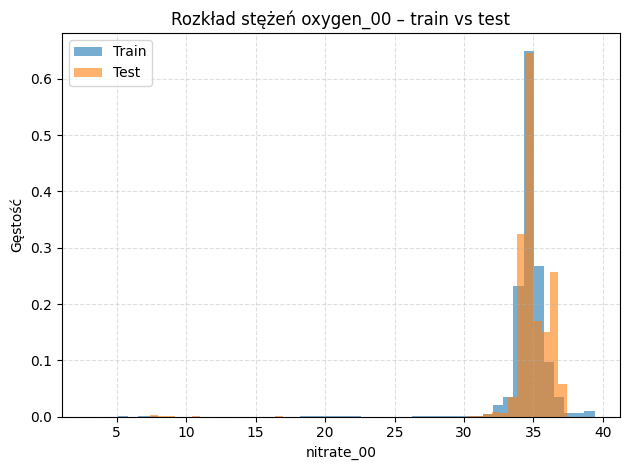

In [ ]:
plt.hist(y_train.numpy(), bins=50, alpha=0.6, label='Train', density=True)
plt.hist(y_test, bins=50, alpha=0.6, label='Test', density=True)
plt.legend()
plt.title("Rozkład stężeń oxygen_00 – train vs test")
plt.xlabel("nitrate_00")
plt.ylabel("Gęstość")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

<ipython-input-14-2115757900>:9: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


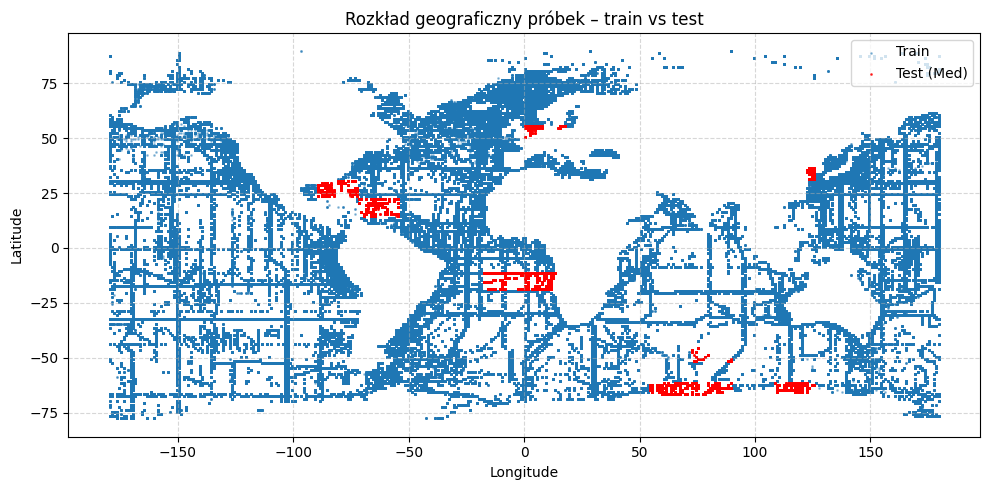

In [ ]:
plt.figure(figsize=(10,5))
plt.scatter(df[~test_mask]["lon"], df[~test_mask]["lat"], s=1, label="Train", alpha=0.4)
plt.scatter(df[test_mask]["lon"], df[test_mask]["lat"], s=1, label="Test (Med)", alpha=0.7, color="red")
plt.legend()
plt.title("Rozkład geograficzny próbek – train vs test")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

## Training loop

In [ ]:
def train(model_, loader_, n_epochs=20, lr=1e-3, weight_decay=1e-4, verbose=True, gradient_clipping=False):
    opt = torch.optim.Adam(model_.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=n_epochs)
    loss_fn = nn.MSELoss()

    for epoch in range(n_epochs):
        model_.train()
        total_loss = 0
        all_y = []
        all_pred = []

        for x, y in loader_:
            x, y = x.cuda(), y.cuda()
            pred = model_(x).flatten()

            loss = loss_fn(pred, y)
            loss.backward()

            if gradient_clipping:
                torch.nn.utils.clip_grad_norm_(model_.parameters(), max_norm=1.0)

            opt.step()
            opt.zero_grad()

            total_loss += loss.item()
            all_y.append(y.detach().cpu())
            all_pred.append(pred.detach().cpu())

        scheduler.step()

        # Concatenate all predictions and targets
        all_y = torch.cat(all_y).numpy()
        all_pred = torch.cat(all_pred).numpy()

        r2 = r2_score(all_y, all_pred)
        avg_loss = total_loss / len(loader_)

        if verbose:
            print(f"Epoch {epoch+1}: loss = {avg_loss:.4f}  R2 = {r2:.4f}")

    return avg_loss, r2

def metrics(name, y, pred, verbose=True):
    mse = mean_squared_error(y, pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y, pred)
    r2   = r2_score(y, pred)
    if verbose:
        print(f"{name:<18} RMSE={rmse:.4f} MSE={mse:.4f} MAE={mae:.4f} R2={r2:.4f}")
    return mse, rmse, mae, r2



def evaluate(name, model_, loader_):
    model_.eval()
    for x, y in loader_:
        x, y = x.cuda(), y.cuda()
        pred = model_(x).flatten()
        y = y.detach().cpu().numpy()
        pred = pred.detach().cpu().numpy()
        return metrics(name, y, pred)


def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LayerNorm):
        nn.init.ones_(m.weight)
        nn.init.zeros_(m.bias)

## Sanity check: linear prediction without embeddings

In [ ]:
class BaselineMLP(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.predictor = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.predictor(x).squeeze(-1)

for _ in range(1):
    torch.manual_seed(42); torch.cuda.manual_seed_all(42)
    pred_model = BaselineMLP(in_dim=9).cuda()
    _ = train(pred_model, train_loader, n_epochs=50, lr=1e-2)
    _ = evaluate("Baseline", pred_model, test_loader)

Epoch 1: loss = 25.0074  R2 = -12.3731
Epoch 2: loss = 1.0227  R2 = 0.4534
Epoch 3: loss = 0.8518  R2 = 0.5445
Epoch 4: loss = 0.7481  R2 = 0.6000
Epoch 5: loss = 0.6844  R2 = 0.6341
Epoch 6: loss = 0.6275  R2 = 0.6646
Epoch 7: loss = 0.5611  R2 = 0.7001
Epoch 8: loss = 0.5325  R2 = 0.7153
Epoch 9: loss = 0.4856  R2 = 0.7404
Epoch 10: loss = 0.4612  R2 = 0.7534
Epoch 11: loss = 0.4178  R2 = 0.7767
Epoch 12: loss = 0.4060  R2 = 0.7829
Epoch 13: loss = 0.3761  R2 = 0.7990
Epoch 14: loss = 0.3516  R2 = 0.8120
Epoch 15: loss = 0.3459  R2 = 0.8152
Epoch 16: loss = 0.3347  R2 = 0.8211
Epoch 17: loss = 0.3148  R2 = 0.8318
Epoch 18: loss = 0.2988  R2 = 0.8403
Epoch 19: loss = 0.2738  R2 = 0.8536
Epoch 20: loss = 0.2656  R2 = 0.8580
Epoch 21: loss = 0.2645  R2 = 0.8587
Epoch 22: loss = 0.2435  R2 = 0.8698
Epoch 23: loss = 0.2412  R2 = 0.8710
Epoch 24: loss = 0.2342  R2 = 0.8752
Epoch 25: loss = 0.2280  R2 = 0.8781
Epoch 26: loss = 0.2251  R2 = 0.8797
Epoch 27: loss = 0.2117  R2 = 0.8868
Epoch 2

## Simple linear prediction

In [ ]:
class LinearPredictionModel(nn.Module):
    def __init__(self, in_dim, mae):
        super().__init__()
        self.mae = mae
        self.predictor = nn.Linear(in_dim, 1)

        for param in self.mae.parameters():
            param.requires_grad = False

    def forward(self, x):
        enc = self.mae.encoder(x)
        return self.predictor(enc)
torch.manual_seed(42); torch.cuda.manual_seed_all(42)
pred_model = LinearPredictionModel(in_dim=128, mae=model).cuda()
pred_model.predictor.apply(initialize_weights)
_ = train(pred_model, train_loader, n_epochs=50, lr=1e-1)

Epoch 1: loss = 46.1770  R2 = -23.6916
Epoch 2: loss = 8.2754  R2 = -3.4243
Epoch 3: loss = 3.7914  R2 = -1.0269
Epoch 4: loss = 2.0837  R2 = -0.1140
Epoch 5: loss = 1.3745  R2 = 0.2652
Epoch 6: loss = 1.0343  R2 = 0.4470
Epoch 7: loss = 0.8421  R2 = 0.5498
Epoch 8: loss = 0.7285  R2 = 0.6107
Epoch 9: loss = 0.6657  R2 = 0.6442
Epoch 10: loss = 0.6290  R2 = 0.6641
Epoch 11: loss = 0.6000  R2 = 0.6792
Epoch 12: loss = 0.5973  R2 = 0.6807
Epoch 13: loss = 0.5951  R2 = 0.6818
Epoch 14: loss = 0.5873  R2 = 0.6860
Epoch 15: loss = 0.5954  R2 = 0.6818
Epoch 16: loss = 0.6023  R2 = 0.6784
Epoch 17: loss = 0.5855  R2 = 0.6870
Epoch 18: loss = 0.5820  R2 = 0.6889
Epoch 19: loss = 0.5892  R2 = 0.6850
Epoch 20: loss = 0.5928  R2 = 0.6831
Epoch 21: loss = 0.5745  R2 = 0.6928
Epoch 22: loss = 0.5734  R2 = 0.6934
Epoch 23: loss = 0.5743  R2 = 0.6934
Epoch 24: loss = 0.5626  R2 = 0.6992
Epoch 25: loss = 0.5632  R2 = 0.6988
Epoch 26: loss = 0.5652  R2 = 0.6979
Epoch 27: loss = 0.5582  R2 = 0.7018
Epoc

In [ ]:
_ = evaluate("Linear prediction", pred_model, test_loader)

Linear prediction  RMSE=0.9718 MSE=0.9444 MAE=0.5521 R2=0.7002


## Multi-layer linear prediction

In [ ]:
class MultiLinearPredictionModel(nn.Module):
    def __init__(self, in_dim, mae):
        super().__init__()
        self.mae = mae
        self.predictor = nn.Sequential(
            nn.Linear(in_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

        for param in self.mae.parameters():
            param.requires_grad = False

    def forward(self, x):
        enc = self.mae.encoder(x)
        return self.predictor(enc)


if os.path.exists(MODEL_PATH):
    print(f"Loading model from {MODEL_PATH}")
    model = MaskedAutoEncoder(in_dim=9, embed_dim=128).cuda()
    model.load_state_dict(torch.load(MODEL_PATH))
    model.eval()
else:
    print(f"MAE model not found!")

for param in model.parameters():
    param.requires_grad = True


torch.manual_seed(42); torch.cuda.manual_seed_all(42)
pred_model = MultiLinearPredictionModel(in_dim=128, mae=model).cuda()
pred_model.predictor.apply(initialize_weights)
_ = train(pred_model, train_loader, n_epochs=50, lr=1e-3)

Loading model from model.pt
Epoch 1: loss = 199.3935  R2 = -105.6260
Epoch 2: loss = 14.5612  R2 = -6.7852
Epoch 3: loss = 5.2424  R2 = -1.8028
Epoch 4: loss = 2.9460  R2 = -0.5750
Epoch 5: loss = 1.9617  R2 = -0.0488
Epoch 6: loss = 1.3669  R2 = 0.2693
Epoch 7: loss = 0.9805  R2 = 0.4760
Epoch 8: loss = 0.7315  R2 = 0.6089
Epoch 9: loss = 0.5679  R2 = 0.6964
Epoch 10: loss = 0.4563  R2 = 0.7560
Epoch 11: loss = 0.3759  R2 = 0.7990
Epoch 12: loss = 0.3138  R2 = 0.8323
Epoch 13: loss = 0.2657  R2 = 0.8579
Epoch 14: loss = 0.2272  R2 = 0.8786
Epoch 15: loss = 0.1966  R2 = 0.8949
Epoch 16: loss = 0.1722  R2 = 0.9080
Epoch 17: loss = 0.1527  R2 = 0.9184
Epoch 18: loss = 0.1369  R2 = 0.9268
Epoch 19: loss = 0.1248  R2 = 0.9333
Epoch 20: loss = 0.1134  R2 = 0.9394
Epoch 21: loss = 0.1039  R2 = 0.9444
Epoch 22: loss = 0.0965  R2 = 0.9484
Epoch 23: loss = 0.0898  R2 = 0.9520
Epoch 24: loss = 0.0847  R2 = 0.9547
Epoch 25: loss = 0.0798  R2 = 0.9574
Epoch 26: loss = 0.0757  R2 = 0.9595
Epoch 27:

In [ ]:
_ = evaluate("Multi-layer linear prediction", pred_model, test_loader)

Multi-layer linear prediction RMSE=0.4265 MSE=0.1819 MAE=0.2728 R2=0.9422


## Linear+Dropout prediction

In [ ]:
class DropoutLinearPredictionModel(nn.Module):
    def __init__(self, in_dim, mae, dropout=0.3):
        super().__init__()
        self.mae = mae
        self.predictor = nn.Sequential(
            nn.LayerNorm(in_dim),
            nn.Linear(in_dim, 256),
            nn.ReLU(),
            nn.Dropout(dropout),           # Reduced from 0.5 to avoid underfitting
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(dropout / 2),       # Add dropout between deeper layers
            nn.Linear(64, 1)
        )

        for param in self.mae.parameters():
            param.requires_grad = False

    def forward(self, x):
        enc = self.mae.encoder(x)
        return self.predictor(enc)

torch.manual_seed(42); torch.cuda.manual_seed_all(42)
if os.path.exists(MODEL_PATH):
    print(f"Loading model from {MODEL_PATH}")
    model = MaskedAutoEncoder(in_dim=9, embed_dim=128).cuda()
    model.load_state_dict(torch.load(MODEL_PATH))
    model.eval()
else:
    print(f"MAE model not found!")

for param in model.parameters():
    param.requires_grad = True
pred_model = DropoutLinearPredictionModel(in_dim=128, mae=model).cuda()
pred_model.predictor.apply(initialize_weights)
_ = train(pred_model, train_loader, n_epochs=50, lr=1e-2, gradient_clipping=True)

Loading model from model.pt
Epoch 1: loss = 22.9218  R2 = -11.2561
Epoch 2: loss = 14.4359  R2 = -6.7180
Epoch 3: loss = 11.0354  R2 = -4.8990
Epoch 4: loss = 9.8804  R2 = -4.2827
Epoch 5: loss = 8.3062  R2 = -3.4392
Epoch 6: loss = 6.1208  R2 = -2.2724
Epoch 7: loss = 3.2195  R2 = -0.7212
Epoch 8: loss = 2.0830  R2 = -0.1135
Epoch 9: loss = 1.5119  R2 = 0.1917
Epoch 10: loss = 1.1100  R2 = 0.4066
Epoch 11: loss = 0.8342  R2 = 0.5540
Epoch 12: loss = 0.6147  R2 = 0.6714
Epoch 13: loss = 0.4679  R2 = 0.7499
Epoch 14: loss = 0.3760  R2 = 0.7990
Epoch 15: loss = 0.2902  R2 = 0.8448
Epoch 16: loss = 0.2416  R2 = 0.8708
Epoch 17: loss = 0.2202  R2 = 0.8823
Epoch 18: loss = 0.1805  R2 = 0.9035
Epoch 19: loss = 0.1596  R2 = 0.9147
Epoch 20: loss = 0.1569  R2 = 0.9161
Epoch 21: loss = 0.1407  R2 = 0.9248
Epoch 22: loss = 0.1379  R2 = 0.9263
Epoch 23: loss = 0.1378  R2 = 0.9263
Epoch 24: loss = 0.1252  R2 = 0.9331
Epoch 25: loss = 0.1165  R2 = 0.9377
Epoch 26: loss = 0.1154  R2 = 0.9383
Epoch 2

In [ ]:
_ = evaluate("Dropout+linear prediction", pred_model, test_loader)

Dropout+linear prediction RMSE=0.3156 MSE=0.0996 MAE=0.1380 R2=0.9684
